In [20]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
rcParams['figure.figsize'] = 10, 5
rcParams['figure.max_open_warning'] = False
%load_ext autoreload
%autoreload 2

In [ ]:
# adapted from https://github.com/MateLabs/All-Conv-Keras/blob/master/allconv.py

from __future__ import print_function
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D, merge
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K
from keras.models import Model
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint,TensorBoard
import pandas
import cv2
import numpy as np
from pathlib import Path


batch_size = 32
nb_classes = 10
nb_epoch = 60

rows, cols = 32, 32

channels = 3

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print (X_train.shape[1:])

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', strides=(2,2)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', strides=(2,2)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding ='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(10, (1, 1), padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
#               optimizer=sgd, 
              optimizer='rmsprop',
              metrics=['accuracy'])


print (model.summary())

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) 

datagen.fit(X_train)
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

callbacks_list = [checkpoint]

# Fit the model on the batches generated by datagen.flow().
history_callback = model.fit_generator(datagen.flow(X_train, Y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        epochs=nb_epoch, validation_data=(X_test, Y_test), callbacks=callbacks_list, verbose=1)

pandas.DataFrame(history_callback.history).to_csv("history.csv")

model.save('keras_allconv.h5')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_75 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_76 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_77 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________

<IPython.core.display.Javascript object>


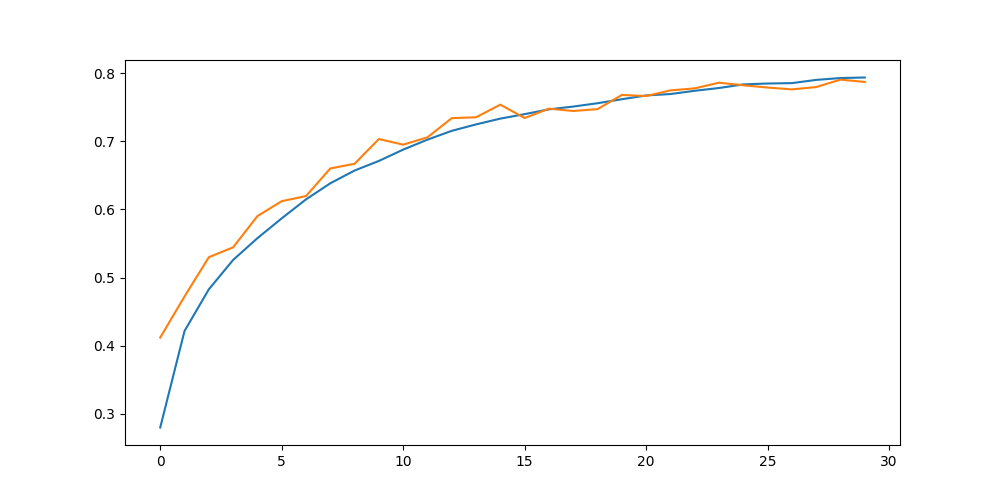

In [22]:
plt.plot(history_callback.history['acc'])
plt.plot(history_callback.history['val_acc'])
plt.show()